# Pix2Pix Generative Adversial Network

![picture](https://phillipi.github.io/pix2pix/images/teaser_v3.png)

![picture](https://www.researchgate.net/publication/362428815/figure/fig1/AS:1184813797130254@1659493030868/Pix2Pix-Conditional-GAN-model-for-paired-image-to-image-translation.png)

## Download Dataset

In [ ]:
!wget https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
!tar -zxvf maps.tar.gz

--2023-09-27 21:44:00--  https://efrosgans.eecs.berkeley.edu/pix2pix/datasets/maps.tar.gz
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 250242400 (239M) [application/x-gzip]
Saving to: ‘maps.tar.gz’

maps.tar.gz         100%[===================>] 238.65M  7.56MB/s    in 56s     

2023-09-27 21:44:56 (4.29 MB/s) - ‘maps.tar.gz’ saved [250242400/250242400]

maps/
maps/train/
maps/train/1.jpg
maps/train/10.jpg
maps/train/100.jpg
maps/train/1000.jpg
maps/train/1001.jpg
maps/train/1002.jpg
maps/train/1003.jpg
maps/train/1004.jpg
maps/train/1005.jpg
maps/train/1006.jpg
maps/train/1007.jpg
maps/train/1008.jpg
maps/train/1009.jpg
maps/train/101.jpg
maps/train/1010.jpg
maps/train/1011.jpg
maps/train/1012.jpg
maps/train/1013.jpg
maps/train/1014.jpg
maps/train/1015.jpg
maps/train/530.jpg
maps/train/

## Import Libraries

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset

import torchvision

import torchvision.transforms as transforms
from torchvision.transforms import InterpolationMode

import os
import cv2
import numpy as np
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

from IPython.display import clear_output
import seaborn as sns
%matplotlib inline

## Preparing CustomDataset
I used val images too when training

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, val_path, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = [os.path.join(data_dir, file_name) for file_name in os.listdir(data_dir)]
        self.val_paths = [os.path.join(val_path, file_name) for file_name in os.listdir(val_path)]
        self.image_paths.extend(self.val_paths)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        pair_img = np.array(Image.open(img_path).convert("RGB"))
        image = pair_img[:,:600]
        target = pair_img[:,600:]

        if self.transform:
            image = self.transform(image)
            target = self.transform(target)

        return image, target
transform_h = transforms.Compose([transforms.ToTensor(),
                                  transforms.Resize((256, 256)),
                                  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
                                  ])
path = "/content/maps/train"
val_path = "/content/maps/val"
dataset = CustomDataset(path, val_path, transform_h)
batch_size = 2
train_loader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

### Take a look to Images

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([2, 3, 256, 256]) torch.Size([2, 3, 256, 256])


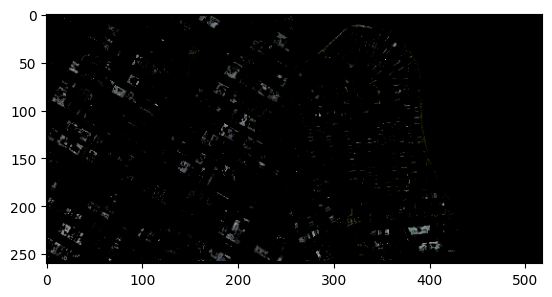

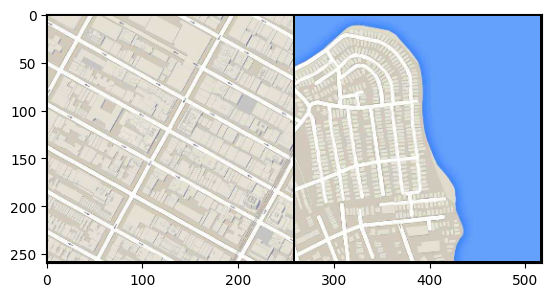

In [ ]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

x_train, y_train = next(iter(train_loader))
print(x_train.shape, y_train.shape)
imshow(torchvision.utils.make_grid(x_train))
imshow(torchvision.utils.make_grid(y_train))

## Unet Generator Model

In [6]:
def conv_block(ch_in,ch_out):
    conv = nn.Sequential(
            nn.Conv2d(ch_in, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out, affine = True),
            nn.ReLU(inplace=True),
            nn.Conv2d(ch_out, ch_out, kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out, affine = True),
            nn.ReLU(inplace=True)
        )
    return conv

class up_conv(nn.Module):
    def __init__(self,ch_in,ch_out):
        super(up_conv,self).__init__()
        self.up = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(ch_in,ch_out,kernel_size=3,stride=1,padding=1,bias=True),
            nn.InstanceNorm2d(ch_out),
            nn.ReLU(inplace=True)
        )

    def forward(self,x):
        x = self.up(x)
        return x

class UNet(nn.Module):
    def __init__(self,img_ch=3, output_ch=3):
        super(UNet,self).__init__()

        self.Maxpool = nn.MaxPool2d(kernel_size=2,stride=2)

        self.Conv1 = conv_block(ch_in=img_ch,ch_out=64)
        self.Conv2 = conv_block(ch_in=64,ch_out=128)
        self.Conv3 = conv_block(ch_in=128,ch_out=256)
        self.Conv4 = conv_block(ch_in=256,ch_out=512)
        self.Conv5 = conv_block(ch_in=512,ch_out=1024)

        self.Up5 = up_conv(ch_in=1024,ch_out=512)
        self.Up_conv5 = conv_block(ch_in=1024, ch_out=512)

        self.Up4 = up_conv(ch_in=512,ch_out=256)
        self.Up_conv4 = conv_block(ch_in=512, ch_out=256)

        self.Up3 = up_conv(ch_in=256,ch_out=128)
        self.Up_conv3 = conv_block(ch_in=256, ch_out=128)

        self.Up2 = up_conv(ch_in=128,ch_out=64)
        self.Up_conv2 = conv_block(ch_in=128, ch_out=64)

        self.Conv_1x1 = nn.Conv2d(64,output_ch,kernel_size=1,stride=1,padding=0)


    def forward(self,x):
        # encoding path
        x1 = self.Conv1(x)

        x2 = self.Maxpool(x1)
        x2 = self.Conv2(x2)

        x3 = self.Maxpool(x2)
        x3 = self.Conv3(x3)

        x4 = self.Maxpool(x3)
        x4 = self.Conv4(x4)

        x5 = self.Maxpool(x4)
        x5 = self.Conv5(x5)

        # decoding + concat path
        d5 = self.Up5(x5)
        d5 = torch.cat((x4, d5),dim=1)
        d5 = self.Up_conv5(d5)

        d4 = self.Up4(d5)
        d4 = torch.cat((x3,d4),dim=1)
        d4 = self.Up_conv4(d4)

        d3 = self.Up3(d4)
        d3 = torch.cat((x2,d3),dim=1)
        d3 = self.Up_conv3(d3)

        d2 = self.Up2(d3)
        d2 = torch.cat((x1, d2),dim=1)
        d2 = self.Up_conv2(d2)

        d1 = self.Conv_1x1(d2)

        return d1

from torchsummary import summary
print(summary(UNet().to("cuda"), (3, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]           1,792
    InstanceNorm2d-2         [-1, 64, 256, 256]             128
              ReLU-3         [-1, 64, 256, 256]               0
            Conv2d-4         [-1, 64, 256, 256]          36,928
    InstanceNorm2d-5         [-1, 64, 256, 256]             128
              ReLU-6         [-1, 64, 256, 256]               0
         MaxPool2d-7         [-1, 64, 128, 128]               0
            Conv2d-8        [-1, 128, 128, 128]          73,856
    InstanceNorm2d-9        [-1, 128, 128, 128]             256
             ReLU-10        [-1, 128, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]         147,584
   InstanceNorm2d-12        [-1, 128, 128, 128]             256
             ReLU-13        [-1, 128, 128, 128]               0
        MaxPool2d-14          [-1, 128,

## PatchGAN Discriminator Model

In [ ]:
import torch.nn as nn
nc = 3
ndf = 32
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc * 2) x 256 x 256``
            nn.Conv2d(nc * 2, ndf * 2, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 128 x 128``

            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 0, bias=False),
            nn.InstanceNorm2d(ndf * 4, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 63 x 63``

            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 0, bias=False),
            nn.InstanceNorm2d(ndf * 8, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf * 8) x 30 x 30``

            nn.Conv2d(ndf * 8, ndf * 16, 4, 1, 0, bias=False),
            nn.InstanceNorm2d(ndf * 16, affine = True),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf * 16) x 27 x 27``

            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

from torchsummary import summary
print(summary(Discriminator().to("cuda"), (6, 256, 256)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           6,144
         LeakyReLU-2         [-1, 64, 128, 128]               0
            Conv2d-3          [-1, 128, 63, 63]         131,072
    InstanceNorm2d-4          [-1, 128, 63, 63]             256
         LeakyReLU-5          [-1, 128, 63, 63]               0
            Conv2d-6          [-1, 256, 30, 30]         524,288
    InstanceNorm2d-7          [-1, 256, 30, 30]             512
         LeakyReLU-8          [-1, 256, 30, 30]               0
            Conv2d-9          [-1, 512, 27, 27]       2,097,152
   InstanceNorm2d-10          [-1, 512, 27, 27]           1,024
        LeakyReLU-11          [-1, 512, 27, 27]               0
          Sigmoid-12          [-1, 512, 27, 27]               0
Total params: 2,760,448
Trainable params: 2,760,448
Non-trainable params: 0
---------------------------

## Defining Loss Functions and Optimizers

In [ ]:
netD = Discriminator().to("cuda")
netG = UNet(3).to("cuda")

optimD = optim.Adam(netD.parameters(), lr = 0.0002, betas=(0.5, 0.999))
optimG = optim.Adam(netG.parameters(), lr = 0.0002, betas=(0.5, 0.999))

BCE_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

loss_weights = [1, 100]

## Model Training

In [ ]:
num_epoch = 50
device = "cuda"
path = "/content/maps/train"
dataset = CustomDataset(path, val_path, transform_h)
batch_size = 4
dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size)

for epoch in range(num_epoch):
    for i, (image, target) in enumerate(dataloader, 0):
      image = image.to(device) #Taking Images
      target = target.to(device)

      ############################
      # (1) Update D network
      ###########################
      netD.zero_grad()

      b_size = image.size(0)
      concated_images = torch.cat([image, target], dim = 1)
      output = netD(concated_images)
      errD_real = BCE_loss(output, torch.ones_like(output))
      errD_real.backward() #calculate the gradients
      D_x = output.mean().item()

      ## Train with all-fake batch
      #COMPUTE PROBABILITY OF FAKE OBJECT TO BE FAKE
      fake = netG(image)
      concated_images = torch.cat([image, fake.detach()], dim = 1)
      output = netD(concated_images)
      errD_fake = BCE_loss(output, torch.ones_like(output))
      errD_fake.backward()
      D_G_z1 = output.mean().item()
      # Compute error of D as sum over the fake and the real batches
      errD = errD_real + errD_fake
      # Update D
      optimD.step()# update weights and bias

      ############################
      # (2) Update G network
      ###########################
      netG.zero_grad()
      concated_images = torch.cat([image, fake], dim = 1)
      output = netD(concated_images)

      loss1 = BCE_loss(output, torch.ones_like(output))
      loss2 = l1_loss(fake, target)
      errG = loss1 + loss_weights[1] * loss2

      errG.backward()
      D_G_z2 = output.mean().item()
      optimG.step()

      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(G(z)): %.4f'
                  % (epoch + 1, num_epoch, i, len(dataloader),
                     errD.item(), errG.item(), D_G_z2))

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


[1/45][0/549]	Loss_D: 0.0197	Loss_G: 3.6427	D(x): 0.9902	D(G(z)): 0.9902 / 0.9902
[1/45][50/549]	Loss_D: 0.0196	Loss_G: 5.1203	D(x): 0.9903	D(G(z)): 0.9903 / 0.9903


KeyboardInterrupt: ignored

## Evaluation

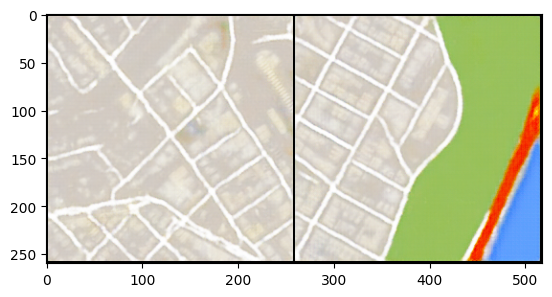

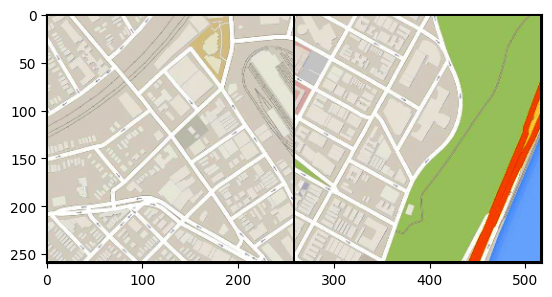

In [ ]:
netG.eval()

x_train, y_train = next(iter(train_loader))
x_train = x_train.to("cuda")

pred = netG(x_train)
pred = torchvision.utils.make_grid(pred)
pred = pred.cpu().detach()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(pred)
imshow(torchvision.utils.make_grid(y_train))

I tested with normal discriminator instead of PatchGAN with 50 Epoch results like this

tensor(1.0000)


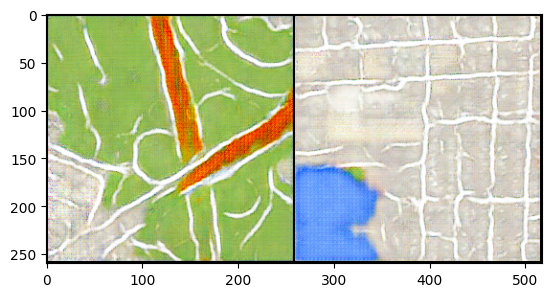

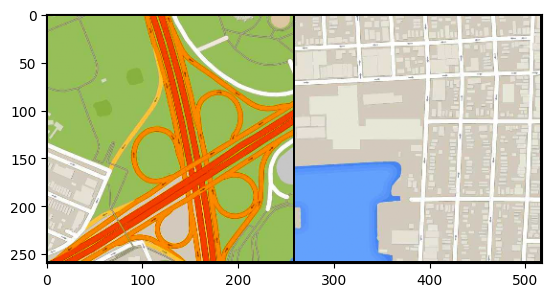

In [ ]:
netG.eval()

x_train, y_train = next(iter(train_loader))
x_train = x_train.to("cuda")

pred = netG(x_train)
pred = torchvision.utils.make_grid(pred)
pred = pred.cpu().detach()

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(pred)
imshow(torchvision.utils.make_grid(y_train))